# Data Extraction and Preprocessing Functions

Prior to any exploratory data analysis (EDA) or machine learning (ML), it is necessary to extract the dataset and occasionally perform initial preprocessing. 

Several functions have been created, each with different objectives, including extraction, data reduction/filtering, normalisation, day creation, etc.  

These have been designed so that they can be run in any order with the option to export to csv at various stages.

## Libraries

In [1]:
# import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Extraction from folder to dataframe

The `Depresjon` dataset is available from https://datasets.simula.no/depresjon/ as a [zip file](https://datasets.simula.no/downloads/depresjon.zip).

The zip file contains
* `condition` folder - individual csv files for depressed individuals
* `control` folder - individual csv files for control csv files
* `scores.csv` - MADRS scores and biodemographic data

The `extract_folder` function extracts individual csv files into a pandas dataframe.  

Optional arguments:
* downsample
* save to csv


In [3]:

def extract_from_folder(folderpath, downsample=None, save_to_csv=False, output_csv_path=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): folder containing CSV files.
      downsample (int, optional): number of rows to downsample CSVs to. Defaults to None.
      save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
      output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # optional downsample 
                if downsample:
                    df = df.sample(downsample)

                # ID column - this is the filename without the extension
                df['id'] = id

                # 'condition' column
                df['condition'] = subfolder

                # convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)


    try:
        if save_to_csv:
            if output_csv_path:
                df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df
    except OSError:
        print("Error saving to CSV.")


Example use of `extract_folder` function:

In [18]:
folderpath = '../data/depresjon'
output_csv_path = '../data/petter/downsample1000K.csv'

# example downsample and store csv
df_1000K = extract_from_folder(folderpath, downsample=1000, save_to_csv=True, output_csv_path=output_csv_path)

# print first 5 rows
print(df_1000K.head())
# print to clipboard
df_1000K.head().to_clipboard()

# check memory usage
#print(df_1000K.memory_usage(deep=True).sum() / 1e6, "MB")
# free memory
del df_1000K


df saved to ../data/petter/downsample1000K.csv
            timestamp       date  activity         id  label
0 2003-04-16 14:13:00 2003-04-16         3  control_1      0
1 2003-03-30 21:06:00 2003-03-30        43  control_1      0
2 2003-03-23 15:58:00 2003-03-23       223  control_1      0
3 2003-04-11 13:40:00 2003-04-11         0  control_1      0
4 2003-03-29 23:32:00 2003-03-29       313  control_1      0


In [ ]:
# full ds, no csv
df = extract_from_folder(folderpath)


In [20]:

# print info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571706 entries, 0 to 1571705
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1571706 non-null  datetime64[ns]
 1   date       1571706 non-null  datetime64[ns]
 2   activity   1571706 non-null  int64         
 3   id         1571706 non-null  object        
 4   label      1571706 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 60.0+ MB
None


## Add 'scores' data to df

The `scores.csv` file contains MADRS depression scores as well as additional biodemographic details such as age, education, marriage status, employment, etc. Most of the data is not available for the `control` group.

The `add_scores` function merges the `scores.csv` with a dataframe.  

Optional arguments: 
* columns to merge on
* save to csv
* limit output to 'condition' only rows


In [9]:
def add_scores(df, scores_df, merge_on_df='id', merge_on_scores='number', save_to_csv=False, output_csv_path=None, include_all_labels=True):
    """
    Adds scores data.

    Args:
        df (pd.DataFrame): extracted df.
        scores_df (pd.DataFrame):  scores df
        merge_on_df (str, optional): col in extracted df to merge on. defaults to 'id'.
        merge_on_scores (str, optional): col in scores df to merge on. defaults to 'number'.
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
        include_all_labels (bool, optional): include all labels. defaults to True. set to False to filter only label=1.

    Returns:
        pd.DataFrame: updated df with scores added.
    """

    import pandas as pd
    try:
        # merge based on specified columns
        merged_df = pd.merge(df, scores_df, left_on=merge_on_df, right_on=merge_on_scores, how='left')
        # Fill missing values with NaN
        merged_df.fillna(value=pd.NA, inplace=True)

        # filter rows based on label
        if 'label' in merged_df.columns:
            if not include_all_labels:
                merged_df = merged_df[merged_df['label'] == 1]

        if save_to_csv:
            if output_csv_path:
                merged_df.to_csv(output_csv_path, index=False)
                print(f"Updated df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        return merged_df
    except KeyError:
        print(f"Error: '{merge_on_df}' column not found in the specified DataFrames.")
        return merged_df


Example use of `add_scores` function: 

In [10]:
scores_df = pd.read_csv('../data/depresjon/scores.csv')

# add scores to downsampled df and save csv for all respondents
df_1000K_scores = add_scores(df, scores_df, save_to_csv=True, output_csv_path='../data/petter/downsample1000K_condition_with_scores.csv', include_all_labels=False)

# add scores to full df, no csv
df_scores = add_scores(df, scores_df)

# free memory
#del df_1000K_scores
#del df_scores



Updated df saved to ../data/petter/downsample1000K_condition_with_scores.csv


In [16]:
# print head where label == 0
print(df_scores[df_scores['label'] == 0].head())
# print head where label == 0 for to table
print(df_scores[df_scores['label'] == 0].head().to_clipboard())


            timestamp       date  activity         id  label     number  days  \
0 2003-03-18 15:00:00 2003-03-18        60  control_1      0  control_1     8   
1 2003-03-18 15:01:00 2003-03-18         0  control_1      0  control_1     8   
2 2003-03-18 15:02:00 2003-03-18       264  control_1      0  control_1     8   
3 2003-03-18 15:03:00 2003-03-18       662  control_1      0  control_1     8   
4 2003-03-18 15:04:00 2003-03-18       293  control_1      0  control_1     8   

   gender    age  afftype  melanch  inpatient   edu  marriage  work  madrs1  \
0       2  25-29      NaN      NaN        NaN  <NA>       NaN   NaN     NaN   
1       2  25-29      NaN      NaN        NaN  <NA>       NaN   NaN     NaN   
2       2  25-29      NaN      NaN        NaN  <NA>       NaN   NaN     NaN   
3       2  25-29      NaN      NaN        NaN  <NA>       NaN   NaN     NaN   
4       2  25-29      NaN      NaN        NaN  <NA>       NaN   NaN     NaN   

   madrs2  
0     NaN  
1     NaN  
2 

In [17]:
# print head where label == 1
print(df_scores[df_scores['label'] == 1].head())
# print head where label == 1 for to table
print(df_scores[df_scores['label'] == 1].head().to_clipboard())
#print(df_scores.head())


                  timestamp       date  activity           id  label  \
1019990 2003-05-07 12:00:00 2003-05-07         0  condition_1      1   
1019991 2003-05-07 12:01:00 2003-05-07       143  condition_1      1   
1019992 2003-05-07 12:02:00 2003-05-07         0  condition_1      1   
1019993 2003-05-07 12:03:00 2003-05-07        20  condition_1      1   
1019994 2003-05-07 12:04:00 2003-05-07       166  condition_1      1   

              number  days  gender    age  afftype  melanch  inpatient   edu  \
1019990  condition_1    11       2  35-39      2.0      2.0        2.0  6-10   
1019991  condition_1    11       2  35-39      2.0      2.0        2.0  6-10   
1019992  condition_1    11       2  35-39      2.0      2.0        2.0  6-10   
1019993  condition_1    11       2  35-39      2.0      2.0        2.0  6-10   
1019994  condition_1    11       2  35-39      2.0      2.0        2.0  6-10   

         marriage  work  madrs1  madrs2  
1019990       1.0   2.0    19.0    19.0  
10

## Preprocess to Full Days

The function `extract_from_folder` extracts all files into a Pandas dataframe.  However, some days for some respondents are 'incomplete' in that there are not 1440 rows (1440 minutes in 24 days).  For some ML models, it is necessary to have a consistent number of rows per timeframe. 

The `preprocess_full_days` function extracts all complete days, i.e. where there are 1440 rows of minute data for each date from `00:00:00` to `23:59:00`.

Optional arguments: 

* option to save csv
* option to print info about resulting df
* option to suppress printing information

In [25]:
# copy df 
tobe_full = df.copy()
#print(tobe_full.info())

In [23]:
def preprocess_full_days(df, save_to_csv=False, output_csv_path=None, print_info=True):
    """
    Extracts full days from a dataframe.

    Args::
    df (DataFrame): input df.
    save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
    output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
    print_info (bool, optional): print info about the df. defaults to True.

    Returns:
    DataFrame: df containing only full days (1440 rows per day).

    """
    

    # group by id and date, count rows, and filter where count equals 1440
    full_days_df = df.groupby(['id', 'date']).filter(lambda x: len(x) == 1440)

    # set index to timestamp
    full_days_df.set_index(['timestamp'], inplace=True)
    
    if print_info:
        # print id and date combinations that don't have 1440 rows
        not_full_days = df.groupby(['id', 'date']).size().reset_index(name='count').query('count != 1440')
        print("\nid and date combinations that don't have 1440 rows and have been removed:\n")
        print(not_full_days)

        # print info
        print("\nfull_days_df info:\n")
        print(full_days_df.info())

        #print full days per id
        print("\nfull days per id:\n")
        print(full_days_df.groupby('id').size()/1440)

        # print min number of days
        print("\nmin number of days per id:\n")
        print(full_days_df.groupby('id').size().min()/1440)
        

    try:
        if save_to_csv:
            if output_csv_path:
                full_days_df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return full_days_df
    except OSError:
        print("Error saving to CSV.")

    return full_days_df



Example use of `preprocess_full_days`:

In [26]:
full_days_df = preprocess_full_days(tobe_full, print_info=True)


id and date combinations that don't have 1440 rows and have been removed:

                id       date  count
0      condition_1 2003-05-07    720
16     condition_1 2003-05-23    924
17    condition_10 2004-08-31    900
32    condition_10 2004-09-15    495
33    condition_11 2004-09-28    870
...            ...        ...    ...
1101     control_7 2003-04-23    610
1102     control_8 2003-11-04    900
1122     control_8 2003-11-24    658
1123     control_9 2003-11-11    900
1143     control_9 2003-12-01    778

[115 rows x 3 columns]

full_days_df info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1481760 entries, 2003-03-19 00:00:00 to 2004-06-09 23:59:00
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   date      1481760 non-null  datetime64[ns]
 1   activity  1481760 non-null  int64         
 2   id        1481760 non-null  object        
 3   label     1481760 non-null  int64         
dt

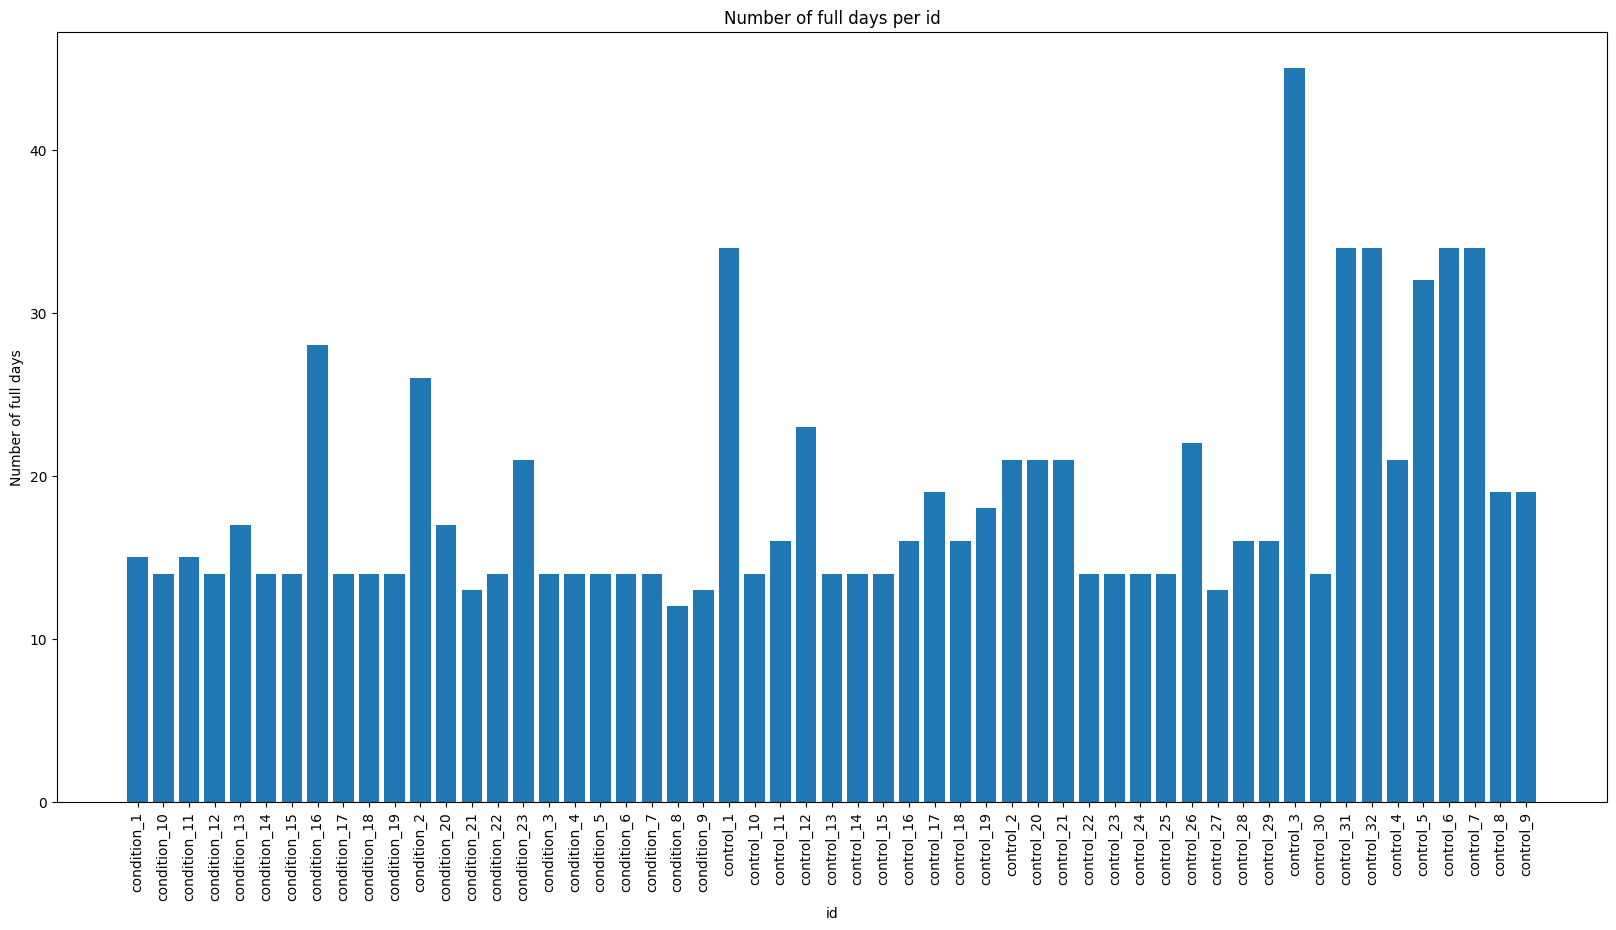

In [30]:
# plot ids on x-axis and number of full days on y-axis
# divide by 1440 to get number of days
plt.figure(figsize=(20,10))
plt.bar(full_days_df.groupby('id').size().index, full_days_df.groupby('id').size()/1440)
plt.title('Number of full days per id')
# rotate x-axis labels
plt.xticks(rotation=90)
plt.xlabel('id')
plt.ylabel('Number of full days')
plt.show()



### Preprocess to Full Days with Start Time

The function `preprocess_full_days` extracted 24 hours worth of data for each date.  This function (`preprocess_full_days_by_start_time`)  creates '24 hour days' based on a 'start time.' For example, if specifying `06:00:00` then Day 1 will run from `06:00:00` to `05:59:00` the following day.  It will inevitably result in fewer days that `extract_full_days`.

Optional arguments:

* start_time - defaults to `00:00`
* option to save csv

In [8]:
tobe_full = df.copy()
#print(tobe_full.info())

In [33]:
def preprocess_full_days_by_start_time(df, start_time='00:00', save_to_csv=False, output_csv_path=None):
    """
    Create numbered 'days' based on the specified start time for each ID.

    Args:
        df (pd.DataFrame): df containing timestamp, id, and other relevant columns.
        start_time (str): start time in 'HH:MM' format (e.g., '06:00').
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
    

    Returns:
        pd.DataFrame: Modified DataFrame with renumbered 'day' column.
    """
    import pandas as pd
    
    # start_time to datetime
    start_datetime = pd.to_datetime(f'1999-01-01 {start_time}:00')

    # day numbers based on start time
    df['day'] = ((df['timestamp'] - start_datetime) // pd.Timedelta(days=1)) + 1

    # filter rows to ensure each day has exactly 1440 rows
    df_filtered = df.groupby(['id', 'day']).filter(lambda x: len(x) == 1440)

    # minimum day for each ID
    min_day_per_id = df_filtered.groupby('id')['day'].min()

    # new column 'renumbered_day'
    df_filtered['renumbered_day'] = df_filtered['day'] - df_filtered['id'].map(min_day_per_id) + 1

    #  drop 'day' column
    df_filtered.drop(columns=['day'], inplace=True)
   
    print(f"New df with 'days' created based on start time: {start_time}")

    try:
        if save_to_csv:
            if output_csv_path:
                df_filtered.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df_filtered
    except OSError:
        print("Error saving to CSV.")

    return df_filtered


Example use of `preprocess_full_days_by_start_time`:

In [34]:
# specify start time
start_time_input = '06:00'
# start time df
full_days_0600 = preprocess_full_days_by_start_time(tobe_full, start_time_input)


New df with 'days' created based on start time: 06:00


In [35]:
print(full_days_0600.head())
# print to clipboard
full_days_0600.head().to_clipboard()

              timestamp       date  activity         id  label  renumbered_day
900 2003-03-19 06:00:00 2003-03-19         0  control_1      0               1
901 2003-03-19 06:01:00 2003-03-19         0  control_1      0               1
902 2003-03-19 06:02:00 2003-03-19         0  control_1      0               1
903 2003-03-19 06:03:00 2003-03-19        83  control_1      0               1
904 2003-03-19 06:04:00 2003-03-19         0  control_1      0               1


## Preprocess by Reducing to a Number of Days

Some ML models require that each respondent has the same number of days.  

The function `reduce_days` reduces a dataframe into the specified number of days.  It defaults to the maximum possible for the dataframe (i.e. the min number of days by id).

Optional arguments:
* number of days - number of days to extract, default = max possible
* option to save csv

In [36]:
def reduce_days(df, num_days=None, save_to_csv=False, output_csv_path=None):
    """
    Extract a specified number of days per ID from the DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame containing relevant columns.
        num_days (int, optional): Number of days to extract (default: None).
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
        pd.DataFrame: Modified DataFrame with the specified number of days per ID.
    """

    import pandas as pd
    # minimum number of days per ID
    min_days_per_id = df.groupby('id').size() // 1440

    if num_days is None:
        # use minimum  
        num_days = min_days_per_id.min()
    elif num_days > min_days_per_id.max():
        # return error if num_days exceeds the minimum
        return f"Max number of extractable days is {min_days_per_id.min()}"

    # filter rows to keep the specified number of days
    df_filtered = df.groupby('id').head(num_days * 1440)

    # save to CSV
    try:
        if save_to_csv:
            if output_csv_path:
                df_filtered.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df_filtered
    except OSError:
        print("Error saving to CSV.")

    return df_filtered


Example use of `reduce_days`: 

In [38]:

# example usage:
reduced_6_days = reduce_days(full_days_0600, num_days=6)
print(reduced_6_days.head())  
# print to clipboard
reduced_6_days.head().to_clipboard()

# max and min number of days per id
print('\nMax days per id:', reduced_6_days.groupby('id').size().max()/1440)
print('Min days per id:', reduced_6_days.groupby('id').size().min()/1440)


              timestamp       date  activity         id  label  renumbered_day
900 2003-03-19 06:00:00 2003-03-19         0  control_1      0               1
901 2003-03-19 06:01:00 2003-03-19         0  control_1      0               1
902 2003-03-19 06:02:00 2003-03-19         0  control_1      0               1
903 2003-03-19 06:03:00 2003-03-19        83  control_1      0               1
904 2003-03-19 06:04:00 2003-03-19         0  control_1      0               1

Max days per id: 6.0
Min days per id: 6.0


## Remove days as per `scores.csv`

Scores csv provides a column called 'days' which specifies the number of days of data for that 'id.' 

The function `extract_days_per_scores` extracts the number of days specified in `scores.csv`

Optional arguments:
* scores filepath


In [68]:
import pandas as pd

def extract_days_per_scores(df, scores_csv_path='..\data\depresjon\scores.csv'):
    """
    Extract the number of days per ID from the 'scores' data.

    Args:
        df (pd.DataFrame): DataFrame containing the 'id' column.
        scores_csv_path (str): Path to the CSV file containing the 'scores' data.
 

    Returns:
        pd.DataFrame: df with the specified number of days per ID based on 'scores'.
    """
    # scores from the CSV file
    scores_df = pd.read_csv(scores_csv_path)

    # merge scores with the df based on the 'id' column
    merged_df = pd.merge(df, scores_df, left_on='id', right_on='number', how='left')

    # filter rows to keep the specified number of days
    df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)

    return df_filtered


Example use: 

In [70]:
scores_csv_path = '../data/depresjon/scores.csv'
# scores days
scores_days = extract_days_per_scores(tobe_full, scores_csv_path)

print(scores_days.head())
# print to clipboard
scores_days.head().to_clipboard()

# print number of days per id
print(scores_days.groupby('id').size()/1440)


            timestamp       date  activity         id  label   day     number  \
0 2003-03-18 15:00:00 2003-03-18        60  control_1      0  1538  control_1   
1 2003-03-18 15:01:00 2003-03-18         0  control_1      0  1538  control_1   
2 2003-03-18 15:02:00 2003-03-18       264  control_1      0  1538  control_1   
3 2003-03-18 15:03:00 2003-03-18       662  control_1      0  1538  control_1   
4 2003-03-18 15:04:00 2003-03-18       293  control_1      0  1538  control_1   

   days  gender    age  afftype  melanch  inpatient  edu  marriage  work  \
0     8       2  25-29      NaN      NaN        NaN  NaN       NaN   NaN   
1     8       2  25-29      NaN      NaN        NaN  NaN       NaN   NaN   
2     8       2  25-29      NaN      NaN        NaN  NaN       NaN   NaN   
3     8       2  25-29      NaN      NaN        NaN  NaN       NaN   NaN   
4     8       2  25-29      NaN      NaN        NaN  NaN       NaN   NaN   

   madrs1  madrs2  
0     NaN     NaN  
1     NaN     Na

C:\Users\zoona\AppData\Local\Temp\ipykernel_35660\4280563994.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)


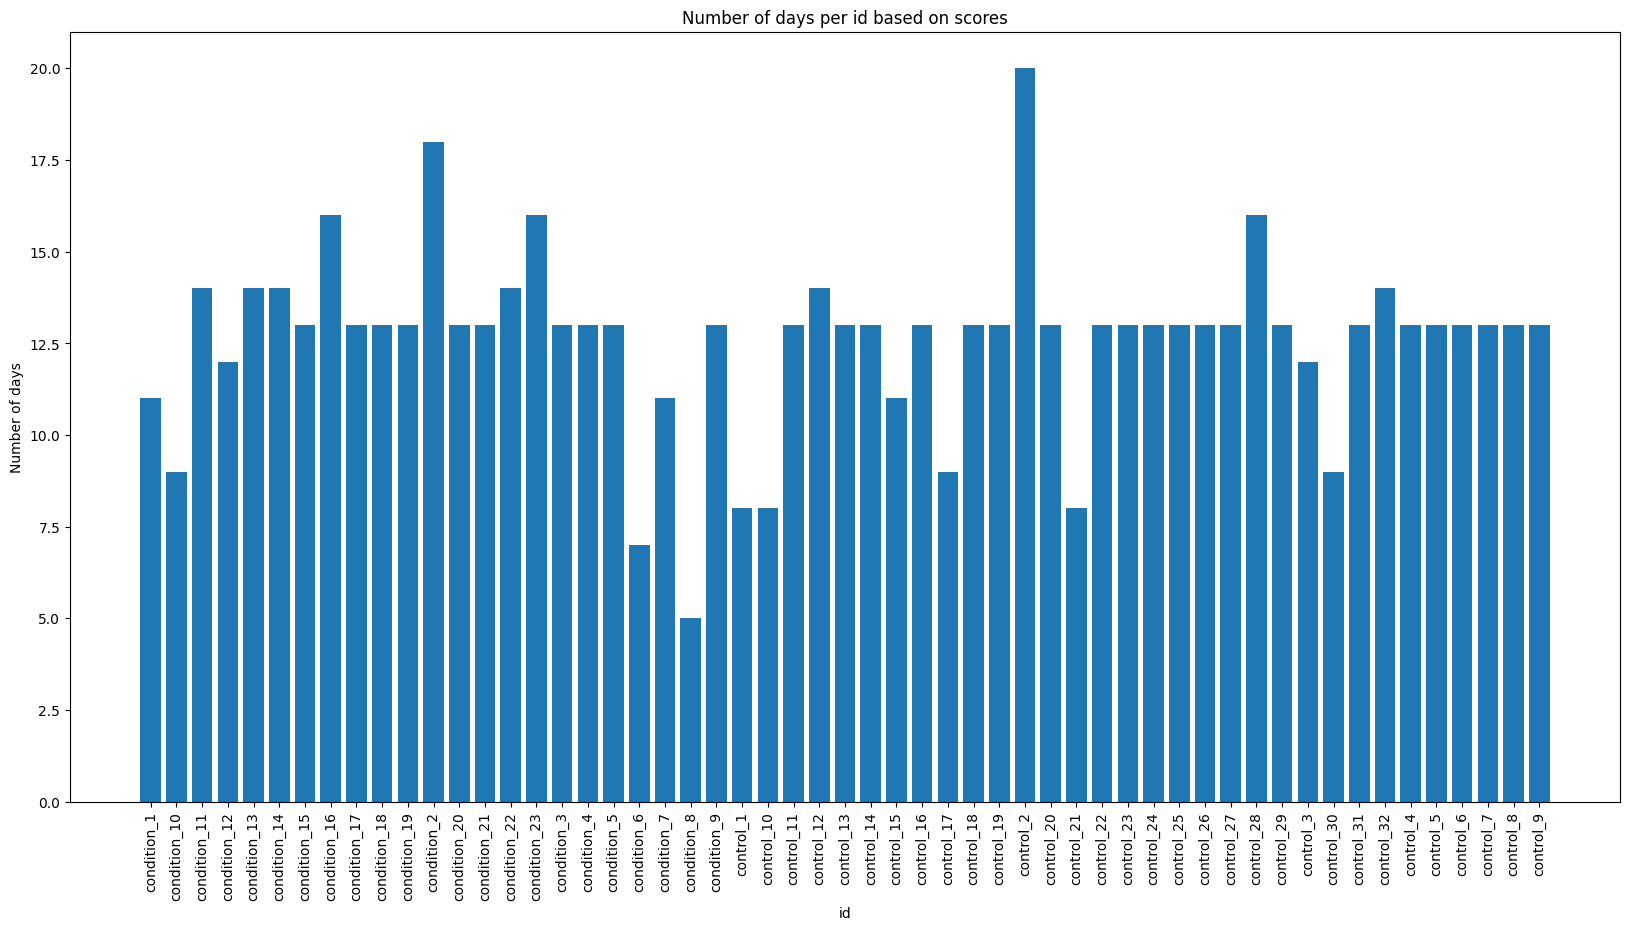

In [71]:
# plot id on x-axis and number of days on y-axis
plt.figure(figsize=(20,10))
plt.bar(scores_days.groupby('id').size().index, scores_days.groupby('id').size()/1440)
plt.title('Number of days per id based on scores')
plt.xticks(rotation=90)
plt.xlabel('id')
plt.ylabel('Number of days')
plt.show()


C:\Users\zoona\AppData\Local\Temp\ipykernel_35660\1583339277.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([int(i) for i in plt.gca().get_yticks()/1440])


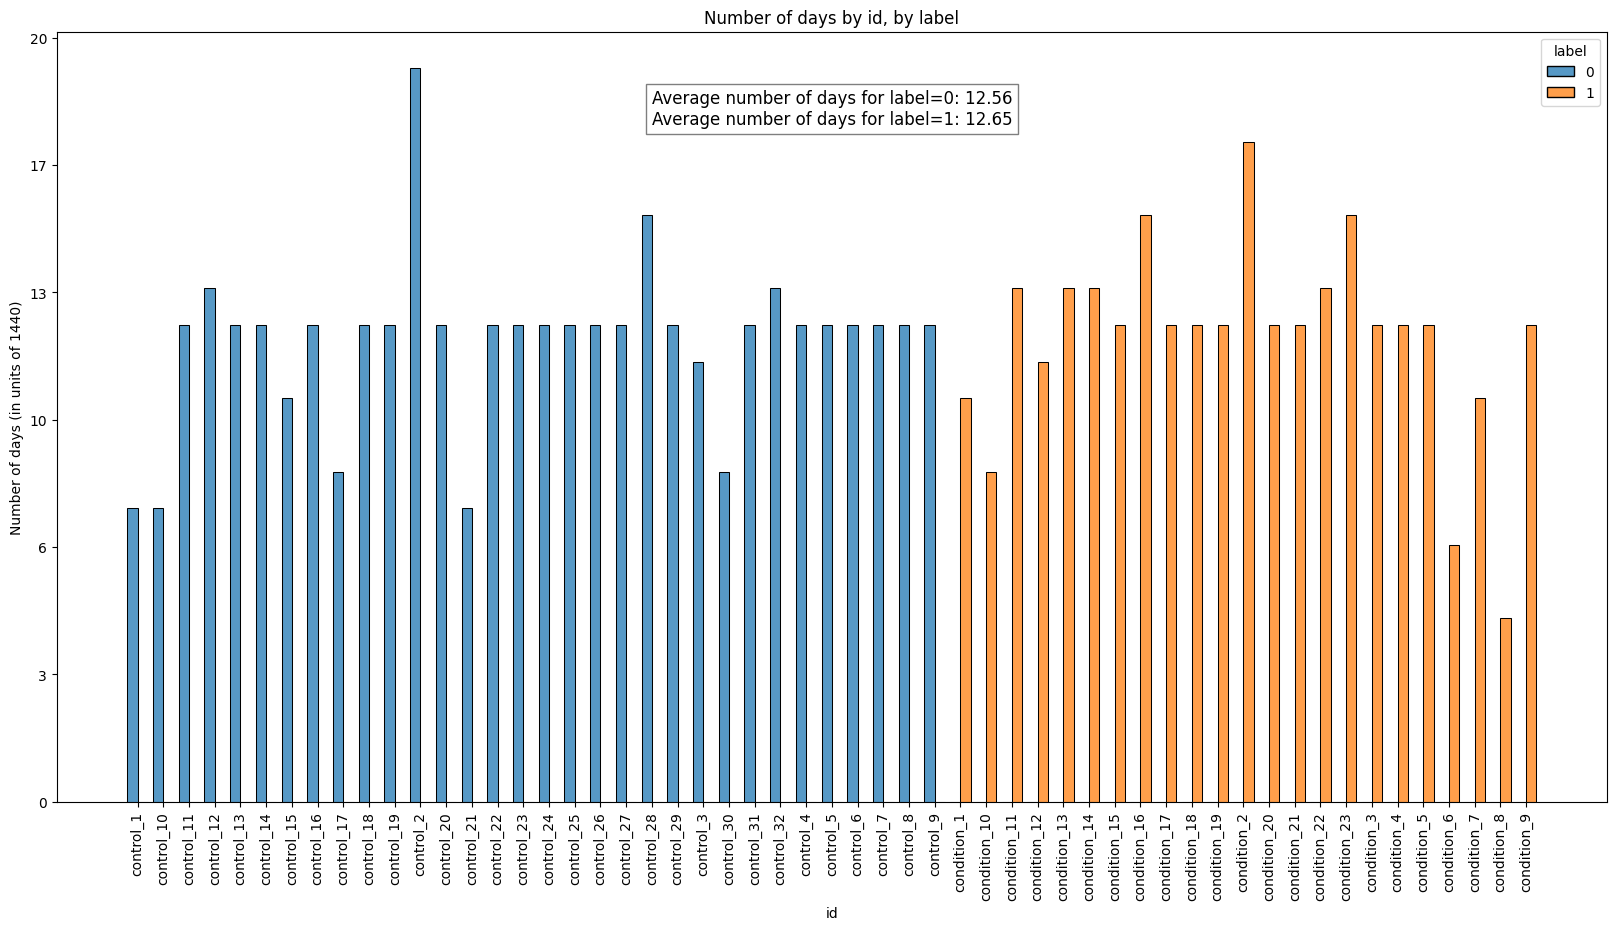

In [79]:
# plot histogram of days by id, by label
plt.figure(figsize=(20,10))
sns.histplot(data=scores_days, x='id', hue='label', multiple='dodge', shrink=.8)
plt.title('Number of days by id, by label')
plt.xticks(rotation=90)
plt.xlabel('id')
plt.ylabel('Number of days (in units of 1440)')
plt.gca().set_yticklabels([int(i) for i in plt.gca().get_yticks()/1440])
# add text box with average number of days for each label
plt.text(0.5, 0.9, f"Average number of days for label=0: {scores_days[scores_days['label'] == 0].groupby('id').size().mean()/1440:.2f}\nAverage number of days for label=1: {scores_days[scores_days['label'] == 1].groupby('id').size().mean()/1440:.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.show()




## Removing days which have no Activity

The filtering and reduction functions *may* ensure that the dataframe does not contain days with zero activity for a respondent.  However, if these steps are not undertaken, the extracted data will contain zero-activity days.  

For example: 

![control_1 hourly plot](./hourly_control_1.png)

![condition_1 hourly plot](./hourly_condition_1.png)



It may be decided that days with zero activity (sum = 0) should be excluded as it may adversely affect a ML model.

The function `remove_zero_sum_activity` does this.

Optional arguments:
* save to csv
* removed rows to df

In [85]:
def remove_zero_sum_activity(df, save_to_csv=False, output_csv_path=None, removed=False):
    """
    Filters out days with zero total activity.

    Args:
        df (pd.DataFrame): df with columns 'id', 'date', and 'activity'.
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
        removed (bool, optional): return removed rows? defaults to False.

    Returns:
        pd.DataFrame: df with non-zero total activity.
    """

    import pandas as pd

    # group by 'id' and 'date', calculate the sum of 'activity'
    df['date'] = pd.to_datetime(df['date'])
    df_sum = df.groupby(['id', 'date'])['activity'].sum()

    # filter out the days with zero total activity
    df_sum = df_sum[df_sum != 0]

    # filter the original df to only include these 'id' and 'date' combinations
    df_no_zero = df[df.set_index(['id', 'date']).index.isin(df_sum.index)].copy()

    # make 'date' a datetime object again
    df_no_zero['date'] = pd.to_datetime(df_no_zero['date'])

    # print rows if print_rows is True
    if removed:
        # create df with removed rows
        removed_rows = df[~df.set_index(['id', 'date']).index.isin(df_sum.index)].copy()
        return df_no_zero, removed_rows


    # save to CSV
    if save_to_csv:
        if output_csv_path:
            df_no_zero.to_csv(output_csv_path, index=False)
            print(f"Filtered DataFrame saved to {output_csv_path}")
        else:
            print("Please provide a valid output_csv_path to save the DataFrame.")

    return df_no_zero

Example use of `remove_zero_sum_activity` function.

There are 70 `(date, id)` combinations which have activity sum == 0 when extracting files directly from the folder. 

In [15]:
# print days per id where sum of activity is 0
print("Date, id combinations with zero activity:", len(tobe_full.groupby(['id', 'date'])['activity'].sum().loc[lambda x: x == 0]))

Date, id combinations with zero activity: 70


In [86]:
# Example usage:
filtered_df, removed = remove_zero_sum_activity(df, removed=True)

# print days per id where sum of activity is 0
print("Date, id combinations with zero activity:", len(filtered_df.groupby(['id', 'date'])['activity'].sum().loc[lambda x: x == 0]))
#print(filtered_df.info())

# print days per id in removed df
print("Date, id combinations with zero activity in removed df:", len(removed.groupby(['id', 'date'])['activity'].sum().loc[lambda x: x == 0]))

Date, id combinations with zero activity: 0
Date, id combinations with zero activity in removed df: 70


## Resampling

It is often required that the data needs to be resampled into other frequencies - for example from minute data to hourly or daily or 48-hourly.

The function `resample` allows for this.

Optional arguments:
* column to resample
* frequency

In [87]:
# filtered info
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1470906 entries, 0 to 1571705
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1470906 non-null  datetime64[ns]
 1   date       1470906 non-null  datetime64[ns]
 2   activity   1470906 non-null  int64         
 3   id         1470906 non-null  object        
 4   label      1470906 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 67.3+ MB
None


In [88]:

# resample  - mean, median, sum
def resample(df, resample_col='activity', frequency='h', save_to_csv=False, output_csv_path=None):
    """
    Resamples a df based on a given timestamp column and aggregates the resampled data.

    Args:
        df (pandas.DataFrame): input df.
        resample_col (str, optional): column to resample. defaults to 'activity'.
        frequency (str, optional): resampling frequency. defaults to 'h'.
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.


    Returns:
        pandas.DataFrame: The resampled and aggregated DataFrame.
    """
    import pandas as pd
    
    # copy df
    df2 = df.copy()
    
    # convert 'timestamp' column to datetime type
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
    
    # convert 'timestamp' column to DatetimeIndex
    df2.set_index('timestamp', inplace=True)
    
    # resample data and calculate mean, sum, and median
    df_resampled = df2.groupby('id')[resample_col].resample(frequency).agg(['mean', 'sum', 'median'])
    
    # reset index
    df_resampled = df_resampled.reset_index()
    
    # add label column
    df_label = df2.groupby(['id', df2.index.date])['label'].first()
    
    # reset index
    df_label = df_label.reset_index()
    
    # rename columns
    df_label.columns = ['id', 'date', 'label']
    
    # convert date to datetime
    df_resampled['date'] = df_resampled['timestamp'].dt.date
    
    # merge dataframes
    df_final = pd.merge(df_resampled, df_label, on=['id', 'date'])

    # change date to datetime
    df_final['date'] = pd.to_datetime(df_final['date'])

    # save to CSV
    if save_to_csv:
        if output_csv_path:
            df_final.to_csv(output_csv_path, index=False)
            print(f"df saved to {output_csv_path}")
        else:
            print("Error: Please provide an output CSV path.")
    
    return df_final




Example use of `resample`:

In [89]:
# resample hourly
hour01 = resample(filtered_df, frequency='h', save_to_csv=True, output_csv_path='../data/petter/resampled_hourly.csv')
hour24 = resample(filtered_df, frequency='24h')

df saved to ../data/petter/resampled_hourly.csv


In [90]:
# print head
print(hour24.head())
# print to clipboard
hour24.head().to_clipboard()

            id  timestamp        mean     sum  median       date  label
0  condition_1 2003-05-07  174.144444  125384    76.0 2003-05-07      1
1  condition_1 2003-05-08  156.247222  224996    27.0 2003-05-08      1
2  condition_1 2003-05-09  124.135417  178755    14.0 2003-05-09      1
3  condition_1 2003-05-10  134.961806  194345    33.0 2003-05-10      1
4  condition_1 2003-05-11   99.439583  143193    15.0 2003-05-11      1


## Normalising dataframe

Several ML models require or perform better if the dataframe is normalised with a mean of 0 and standard deviation of 1. 

The function `normalise_data` achieves this.

Optional arguments:
* columns to normalise
* save to csv
  

In [92]:
def normalise_data(df, columns_to_normalise, save_to_csv=False, output_csv_path=None):
    """
    Normalises the specified columns in the df using StandardScaler.

    Args:
    - df (pandas.DataFrame): df to be normalised.
    - columns_to_normalise (list): list of column names to be normalised.
    - save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
    - output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
    - df (pandas.DataFrame): The DataFrame with the specified columns normalised.
    """
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    df[columns_to_normalise] = scaler.fit_transform(df[columns_to_normalise])

    if save_to_csv:
        if output_csv_path:
            df.to_csv(output_csv_path, index=False)
            print(f"df saved to {output_csv_path}")
            return df
        else:
            print("Error: Please provide an output CSV path.")

    return df

Example use of `normalise_data`:

In [93]:
# normalise data
normalised_hour24 = normalise_data(hour01, columns_to_normalise=['mean', 'sum', 'median'], save_to_csv=True, output_csv_path='../data/petter/normalised_hourly.csv')

df saved to ../data/petter/normalised_hourly.csv


In [102]:
print(normalised_hour24.head())

            id           timestamp      mean       sum    median       date  \
0  condition_1 2003-05-07 12:00:00  0.615020  0.615521  0.579190 2003-05-07   
1  condition_1 2003-05-07 13:00:00  0.368859  0.369364  0.482272 2003-05-07   
2  condition_1 2003-05-07 14:00:00  0.347479  0.347985  0.215211 2003-05-07   
3  condition_1 2003-05-07 15:00:00  0.107606  0.108117 -0.094925 2003-05-07   
4  condition_1 2003-05-07 16:00:00  0.186108  0.186617  0.107525 2003-05-07   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  


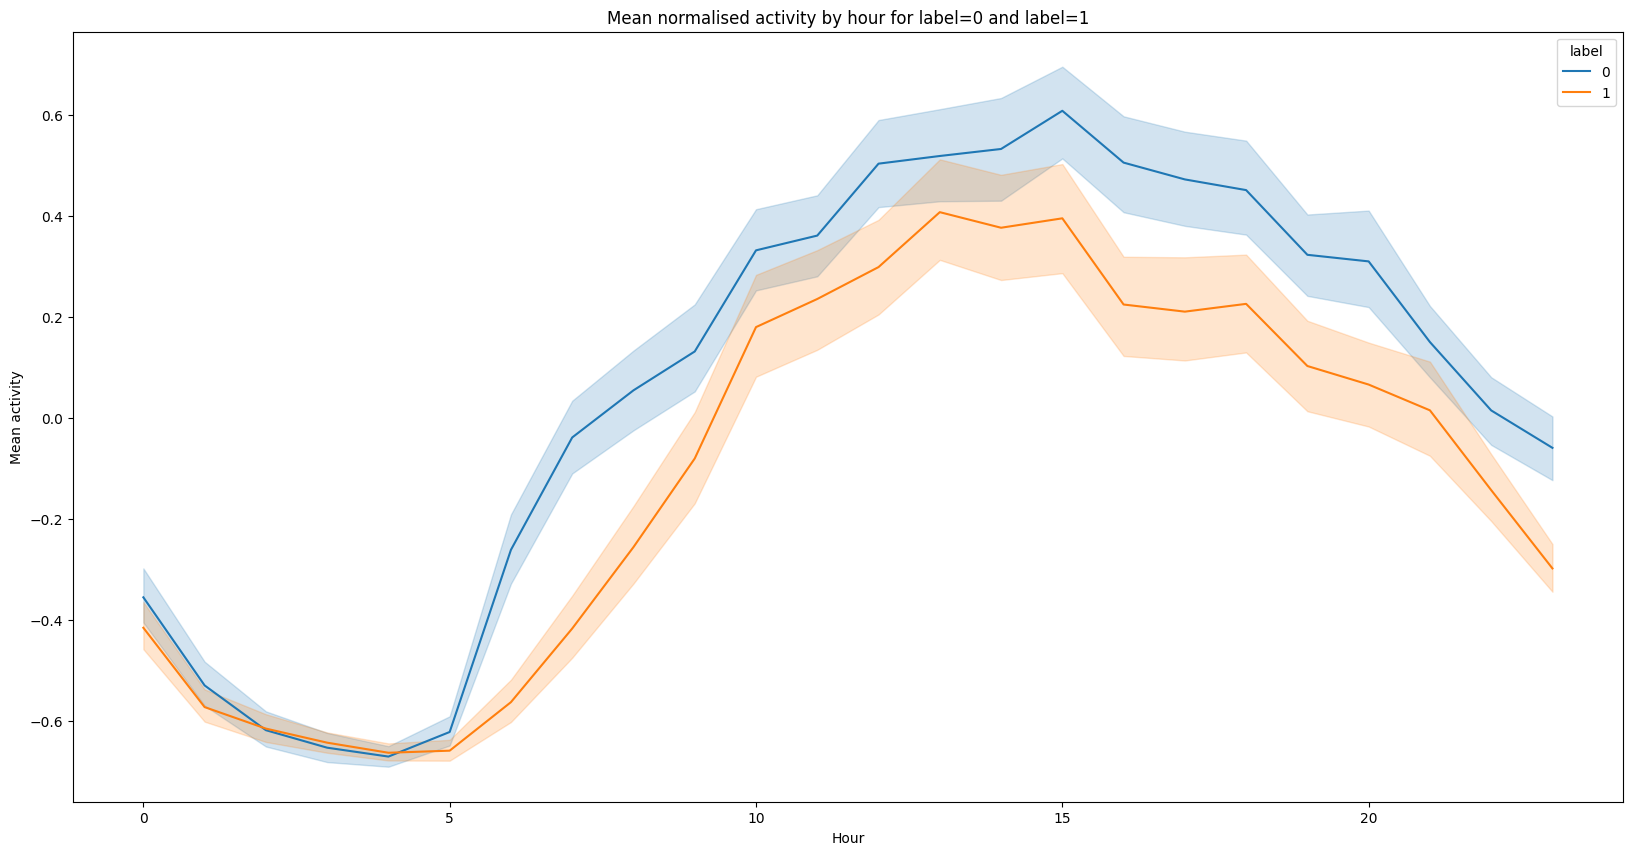

In [104]:
# create hour column
normalised_hour24['hour'] = normalised_hour24['timestamp'].dt.hour

# plot mean activity by hour for label=0 and label=1
plt.figure(figsize=(20,10))
sns.lineplot(data=normalised_hour24, x='hour', y='mean', hue='label')
plt.title('Mean normalised activity by hour for label=0 and label=1')
plt.xlabel('Hour')
plt.ylabel('Mean activity')
plt.show()


## Additional / advanced filtering on activity levels

Some ids have days with `non-zero` but *suspiciously* little activity; so much so that it has to be considered whether they should be included in the models.  For example, `control_17`, `control_19` and `control_20` below have *flatlines* where very little activity is recorded. 

If this is deemed to be spurious, it could be excluded - **although this filtering should be undertaken with care as it could exclude genuine data**.

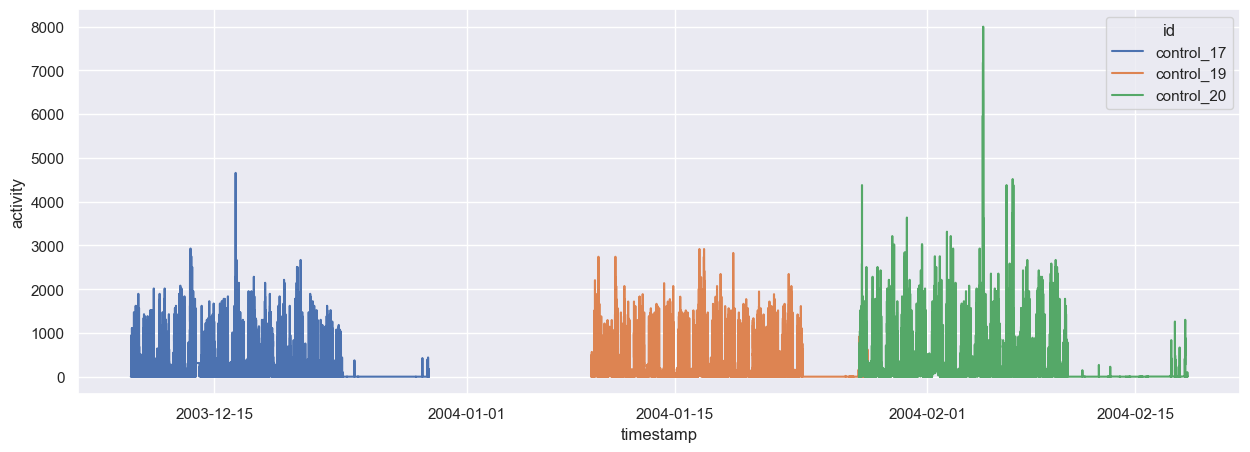

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# filter to only include control_19, control_20, and control_17
control_19_20_17 = filtered_df[filtered_df['id'].isin(['control_19', 'control_20', 'control_17'])]

# plot
sns.lineplot(data=control_19_20_17, x='timestamp', y='activity', hue='id')
plt.show()


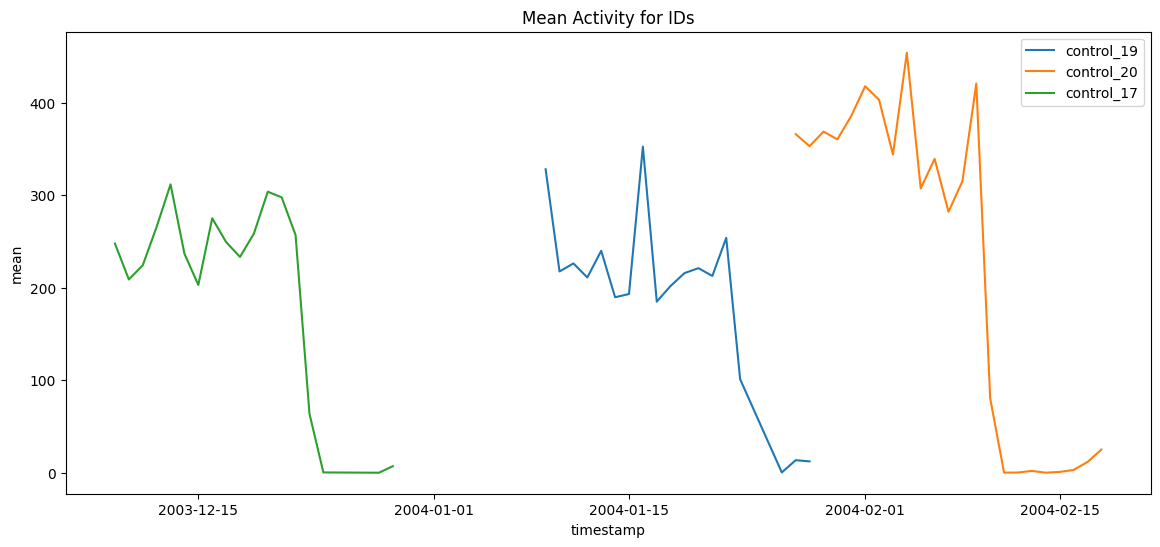

In [21]:

# plot function
def plot_activity_by_id(df, agg, id):
    plt.figure(figsize=(14, 6))
    df_id = df[df['id'] == id]
    sns.lineplot(x='timestamp', y= agg, hue='label', data=df_id)
    plt.title(f'{agg} Activity for ID: {id}')
    plt.show()

    # sample controls 
ids2 = ['control_19','control_20', 'control_17']

plt.figure(figsize=(14, 6))

for id in ids2:
    df_id = hour24[hour24['id'] == id]
    sns.lineplot(x='timestamp', y='mean', data=df_id, label=id)

plt.title('Mean Activity for IDs')
plt.legend()
plt.show()


The above plots show the 'flatline' effect - where it has to be asked if the last days of these recordings are genuine?

* Were the actigraphy recording devices left on after they were removed/returned?
* Should these days be filtered out?
* How?

Looking at the disbributions for daily data by `label`, they appear to have different distributions.

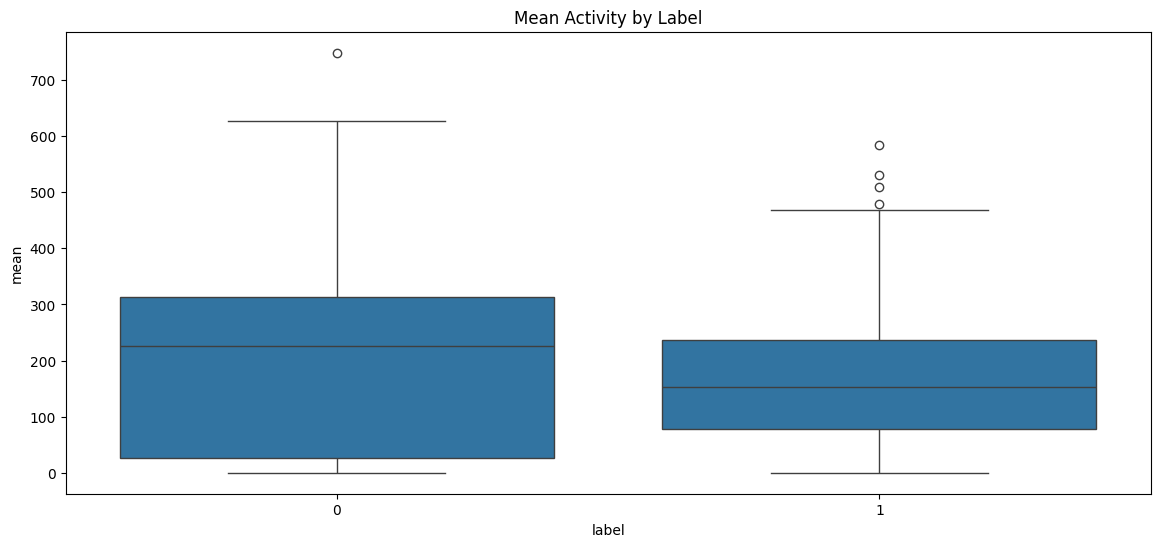

In [22]:
# boxplots of mean activity by label for resampled data
plt.figure(figsize=(14, 6))
sns.boxplot(data=hour24, x='label', y='mean')
plt.title('Mean Activity by Label')
plt.show()

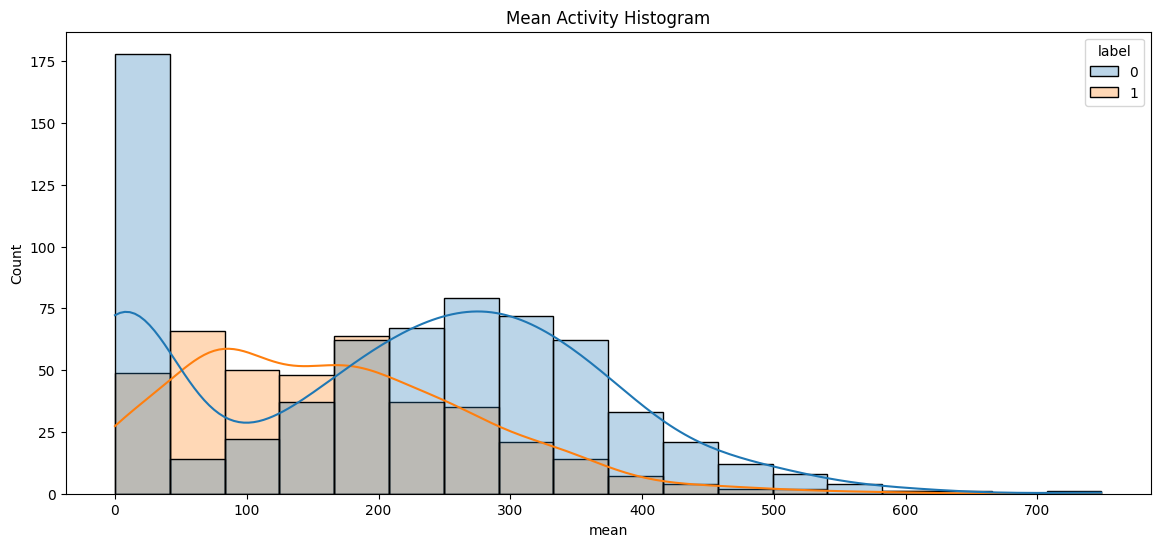

In [25]:
# plot historgram of mean activity (hour24)
plt.figure(figsize=(14, 6))
sns.histplot(data=hour24, x='mean', hue='label', kde=True, alpha = 0.3)
plt.title('Mean Activity Histogram')
plt.show()

We can check for statistically significant difference with a t-test with an alpha of 0.5 using a t-test:

In [129]:
# statistical test to check difference in mean between groups
from scipy.stats import ttest_ind
# condition group
condition = hour24[hour24['label'] == 1]['mean']
# control group
control = hour24[hour24['label'] == 0]['mean']
# perform t-test
t_stat, p_value = ttest_ind(condition, control)
print(f't-statistic: {t_stat}, p-value: {p_value}')
# interpret the result
alpha = 0.05
if p_value > alpha:
    print('Fail to reject H0 (same distributions) at alpha = {}'.format(alpha))
else:
    print('\nReject H0 at alpha = {} and conclude different distributions'.format(alpha))



t-statistic: -4.978526140631887, p-value: 7.461421386758833e-07

Reject H0 at alpha = 0.05 and conclude different distributions


They are different, so removal of rows by a `cutoff` or`threshold` value may need to be done by label.

How to identify the cutoff?

The example plots below show a clear drop off in activity, followed by several days of non-zero activity.

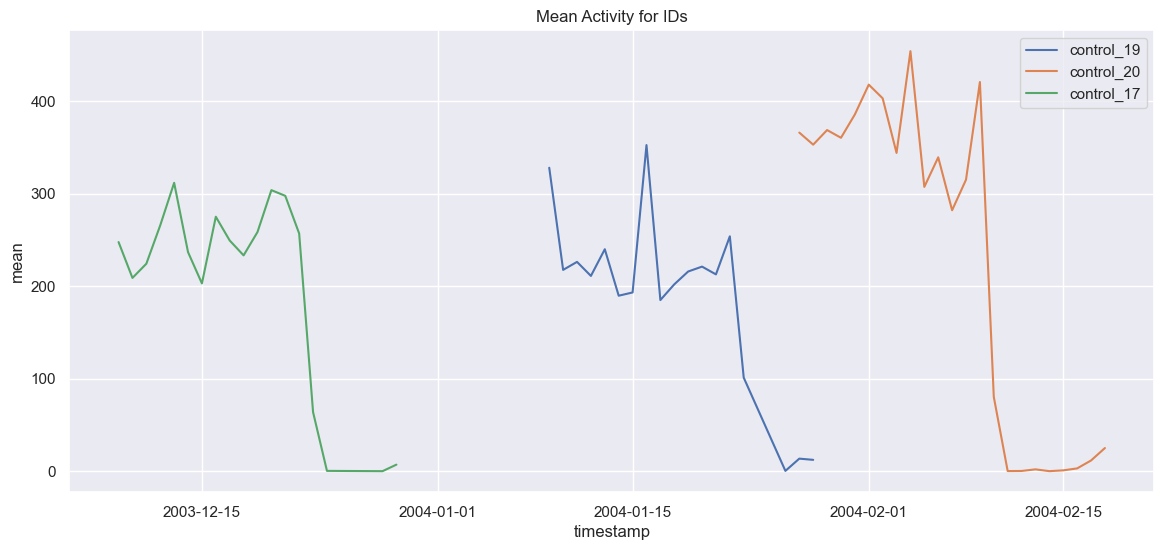

In [130]:
ids = ['condition_1', 'control_1', 'control_3', 'condition_16', 'control_17', 'condition_18', 'control_19', 'control_20']

ids2 = ['control_19','control_20', 'control_17']
plt.figure(figsize=(14, 6))

for id in ids2:
    df_id = hour24[hour24['id'] == id]
    sns.lineplot(x='timestamp', y='mean', data=df_id, label=id)

plt.title('Mean Activity for IDs')
plt.legend()
plt.show()

In [79]:
import pandas as pd

def calculate_mean_difference(df, col_to_average):
    """
    Calculates the mean difference between the specified column and the mean of that column for each unique label.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        col_to_average (str): The column to calculate the mean difference for.

    Returns:
        pandas.DataFrame: df containing the calculated mean difference for each group.
    """
    # Calculate the overall mean of the specified column
    overall_mean = df[col_to_average].mean()

    # Group by 'label' and compute the mean for each group
    grouped_means = df.groupby('label')[col_to_average].mean()

    # Create a new dataframe with the desired columns
    result_df = pd.DataFrame({
        'id': df['id'],
        'date': df['date'],
        col_to_average: df[col_to_average],
        'label_mean': grouped_means[df['label']].values,
        'difference': df[col_to_average] - grouped_means[df['label']].values, 
        'percentage_difference': ((df[col_to_average] - grouped_means[df['label']].values) / grouped_means[df['label']].values) * 100,
        'overall_mean': overall_mean
    })

    return result_df

             id       date        mean  label_mean  difference  \
555  control_17 2003-12-09  247.751111  205.985304   41.765807   
556  control_17 2003-12-10  208.982639  205.985304    2.997335   
557  control_17 2003-12-11  224.333333  205.985304   18.348029   
558  control_17 2003-12-12  265.879861  205.985304   59.894557   
559  control_17 2003-12-13  311.809722  205.985304  105.824418   
560  control_17 2003-12-14  236.881250  205.985304   30.895946   
561  control_17 2003-12-15  203.014583  205.985304   -2.970721   
562  control_17 2003-12-16  275.151389  205.985304   69.166085   
563  control_17 2003-12-17  249.429167  205.985304   43.443863   
564  control_17 2003-12-18  233.344444  205.985304   27.359141   
565  control_17 2003-12-19  258.607639  205.985304   52.622335   
566  control_17 2003-12-20  303.897222  205.985304   97.911918   
567  control_17 2003-12-21  297.747917  205.985304   91.762613   
568  control_17 2003-12-22  256.972917  205.985304   50.987613   
569  contr

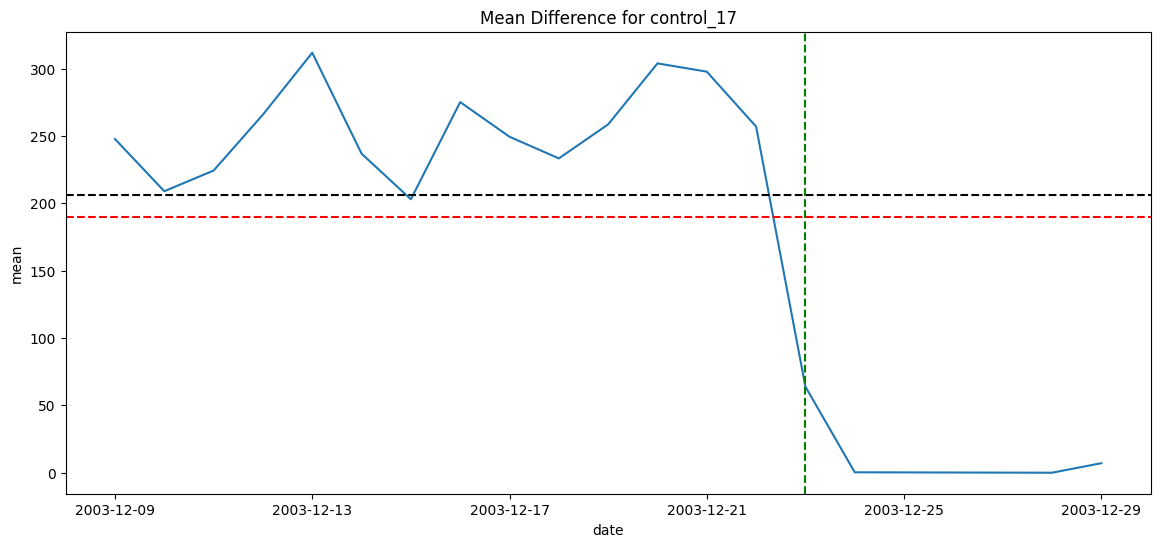

In [80]:
# Calculate mean difference
mean_diff = calculate_mean_difference(hour24, col_to_average='mean')
#print(mean_diff.head())

# print for control_17
print(mean_diff[mean_diff['id'] == 'control_17'])

# plot mean difference around mean for control_17, 
plt.figure(figsize=(14, 6))
sns.lineplot(x='date', y='mean', data=hour24[hour24['id'] == 'control_17'])

#  horizontal line for overall mean
plt.axhline(y=mean_diff['overall_mean'].mean(), color='r', linestyle='--', label='Overall Mean')

#  horizontal line for label mean 
plt.axhline(y=mean_diff[mean_diff['id'] == 'control_17']['label_mean'].mean(), color='black', linestyle='--', label='Label Mean')

# vertical line for date = 2003-12-23
plt.axvline(x=pd.to_datetime('2003-12-23'), color='g', linestyle='--', label = 'Potential cut off date')

plt.title('Mean Difference for control_17')
plt.show()

              id       date        mean  label_mean  difference  \
66  condition_13 2005-08-11  359.184444  162.770746  196.413698   
67  condition_13 2005-08-12  293.556250  162.770746  130.785504   
68  condition_13 2005-08-13  257.502083  162.770746   94.731337   
69  condition_13 2005-08-14  136.571528  162.770746  -26.199218   
70  condition_13 2005-08-15  314.245833  162.770746  151.475087   
71  condition_13 2005-08-16  227.264583  162.770746   64.493837   
72  condition_13 2005-08-17  257.734722  162.770746   94.963976   
73  condition_13 2005-08-18  290.222222  162.770746  127.451476   
74  condition_13 2005-08-19  331.838194  162.770746  169.067448   
75  condition_13 2005-08-20  180.706944  162.770746   17.936198   
76  condition_13 2005-08-21  237.080556  162.770746   74.309810   
77  condition_13 2005-08-22  236.800000  162.770746   74.029254   
78  condition_13 2005-08-23  336.576389  162.770746  173.805643   
79  condition_13 2005-08-24  253.264583  162.770746   90.49383

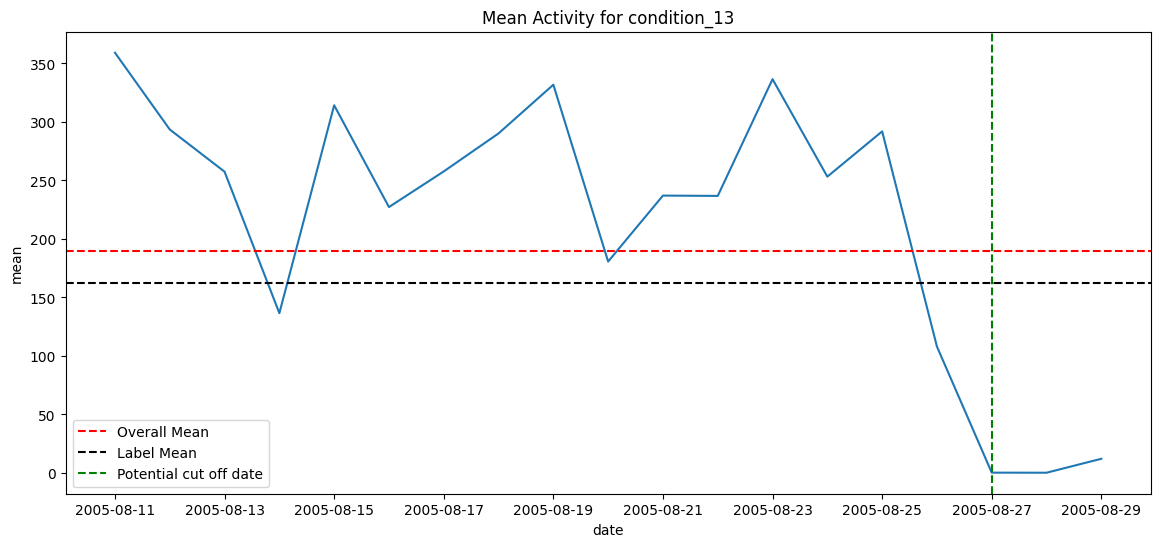

In [81]:
# print for condition_13
print(mean_diff[mean_diff['id'] == 'condition_13'])

# plt daily mean for condition_13
plt.figure(figsize=(14, 6))
sns.lineplot(x='date', y='mean', data=hour24[hour24['id'] == 'condition_13'])

#  horizontal line for overall mean
plt.axhline(y=mean_diff['overall_mean'].mean(), color='r', linestyle='--', label='Overall Mean')

#  horizontal line for label mean 
plt.axhline(y=mean_diff[mean_diff['id'] == 'condition_13']['label_mean'].mean(), color='black', linestyle='--', label='Label Mean')

# vertical line for date = 2005-08-27
plt.axvline(x=pd.to_datetime('2005-08-27'), color='g', linestyle='--', label = 'Potential cut off date')

# legend labels
plt.legend()

plt.title('Mean Activity for condition_13')
plt.show()

### Investigating more closely by date

Looking at the numbers, reasonable cutoffs maybe: 
* condition ~ 50
* control ~ 100

In [84]:
import matplotlib.pyplot as plt

def plot_activity_by_dates(df, id, agg, start_date, end_date, cutoff=None):
    """
    Plot the activity for a specific ID within a given date range.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        id (str): The ID to plot the activity for.
        agg (str): The aggregation method to plot (e.g., 'mean', 'sum', 'median').
        start_date (str): The start date of the date range (format: "YYYY-MM-DD").
        end_date (str): The end date of the date range (format: "YYYY-MM-DD").
        cutoff (float, optional): The cutoff value to plot as a horizontal line. Defaults to None.
    """
    filtered_df = df.query(f'id == "{id}" and date >= "{start_date}" and date <= "{end_date}"')
    
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df.date, filtered_df[agg])
    plt.title(f'{id} activity')
    # add horizontal line at cutoff
    if cutoff:
        plt.axhline(y=cutoff, color='r', linestyle='--')
    plt.xticks(rotation=45)
    plt.show()


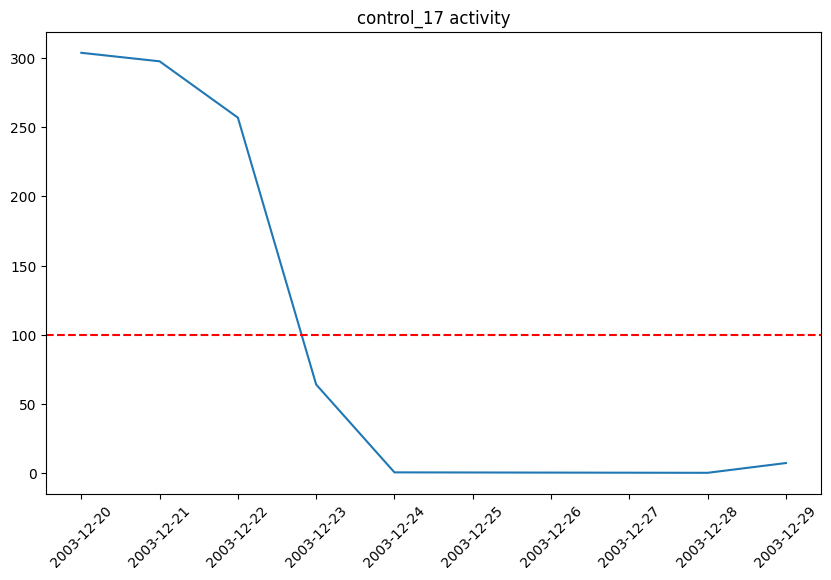

In [91]:
# plot activity for control_17
plot_activity_by_dates(hour24, 'control_17', 'mean','2003-12-20', '2003-12-29', cutoff=100)

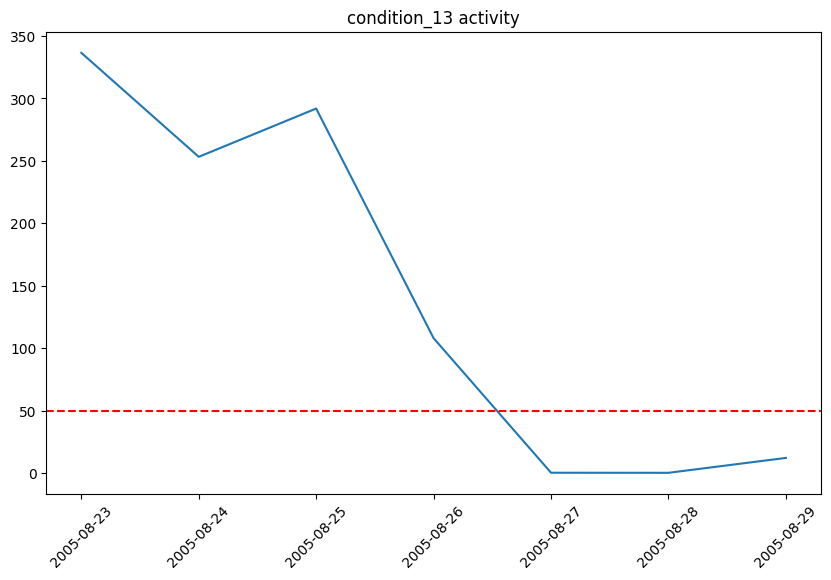

In [92]:
# plot activity for condition_13
plot_activity_by_dates(hour24, 'condition_13', 'mean','2005-08-23', '2005-08-29', cutoff=50)

These values correspond to the 0.27 quantile, approximately:

In [96]:
# 0.27 quantile of daily activity mean for each label
threshold = hour24.groupby('label')['mean'].quantile(0.27)

# sstore the thresholds separately
control_threshold = threshold[1]
condition_threshold = threshold[0]

# print the thresholds
print('Control Threshold:', control_threshold)
print('Condition Threshold:', condition_threshold)

Control Threshold: 80.63407120253164
Condition Threshold: 49.50583333333334


This is the potential impact and needs to be weighed up before committing:

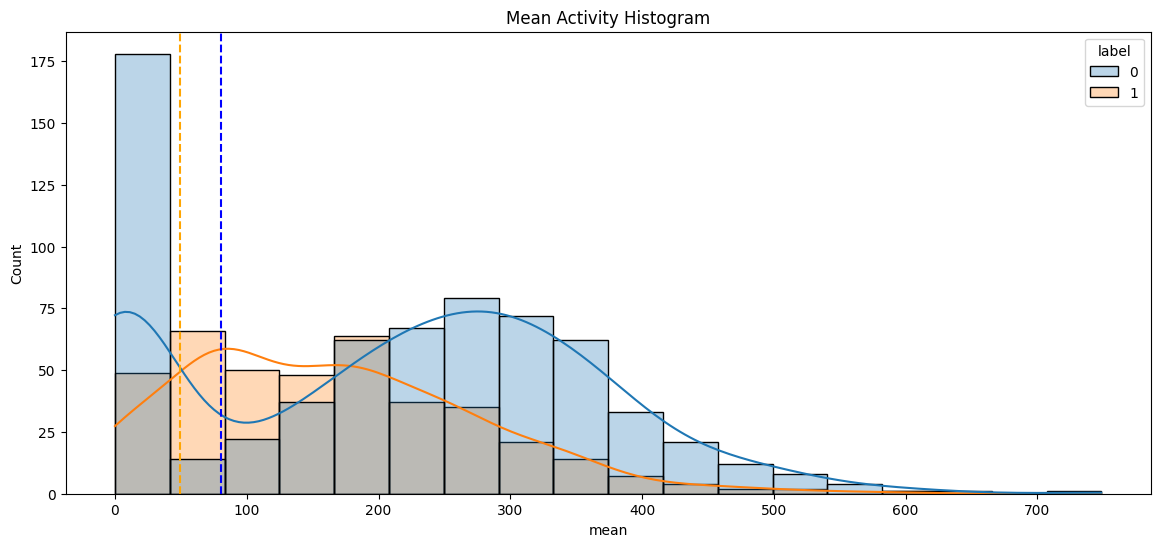

In [100]:
# plot distribution of mean activity with threshold as the cutoff for inclusion
plt.figure(figsize=(14, 6))
sns.histplot(data=hour24, x='mean', hue='label', kde=True, alpha = 0.3)
plt.axvline(x=condition_threshold, color='orange', linestyle='--', label='Condition Threshold')
plt.axvline(x=control_threshold, color='blue', linestyle='--', label='Control Threshold')
plt.title('Mean Activity Histogram')
plt.show()

### Function to remove low activity data

In [113]:
import pandas as pd

def filter_by_threshold(df, col_to_evaluate, threshold_type, threshold_value, print_dropped_info=False, save_to_csv=False, output_csv_path=None):
    """
    Filters rows in the DataFrame based on the specified threshold.

    Args:
        df (pandas.DataFrame): input df.
        col_to_evaluate (str):  column to evaluate.
        threshold_type (str): either 'quantile' or 'value'.
        threshold_value (float): threshold value.
        print_dropped_info (bool, optional): print info about the dropped rows. defaults to False.
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
        
    Returns:
        pandas.DataFrame: The filtered DataFrame.
    """

    if threshold_type == 'quantile':
        if not 0 <= threshold_value <= 1:
            raise ValueError("Quantile threshold value must be between 0 and 1.")
        grouped_quantiles = df.groupby('label')[col_to_evaluate].quantile(threshold_value)
        valid = df[df[col_to_evaluate] >= grouped_quantiles[df['label']].values]
    elif threshold_type == 'value':
        if threshold_value >= df[col_to_evaluate].max():
            raise ValueError("Threshold value must be less than the maximum value of the column.")
        valid = df[df[col_to_evaluate] >= threshold_value]
    else:
        raise ValueError("Invalid threshold type. Choose either 'quantile' or 'value'.")

    if print_dropped_info:
        dropped = df[~df.set_index(['id', 'date']).index.isin(valid.set_index(['id', 'date']).index)]
        print("\nNumber of rows dropped:", len(dropped))
        print("\nIds and dates dropped:")
        print(dropped)
        
    if save_to_csv:
        if output_csv_path:
            valid.to_csv(output_csv_path, index=False)
            print(f"df saved to {output_csv_path}")
            return valid
        else:
            print("Error: Please provide an output CSV path.")
            
    return valid


Example use of `filter_by_threshold`: 

In [111]:

# filter by threshold - quantile
filtered_df = filter_by_threshold(hour24, 'mean', 'quantile', 0.27, print_dropped_info=True)



Ids and dates dropped:
                id  timestamp       mean     sum  median       date  label
15     condition_1 2003-05-22  71.112500  102402     0.0 2003-05-22      1
16     condition_1 2003-05-23   2.991342    2764     0.0 2003-05-23      1
31    condition_10 2004-09-14  64.139583   92361     0.0 2004-09-14      1
32    condition_10 2004-09-15  16.242424    8040     0.0 2004-09-15      1
38    condition_11 2004-10-03  49.852778   71788     0.0 2004-10-03      1
...            ...        ...        ...     ...     ...        ...    ...
1069     control_9 2003-11-27   5.781250    8325     5.0 2003-11-27      0
1070     control_9 2003-11-28   6.401389    9218     7.0 2003-11-28      0
1071     control_9 2003-11-29   6.887500    9918     7.0 2003-11-29      0
1072     control_9 2003-11-30   7.000000   10080     7.0 2003-11-30      0
1073     control_9 2003-12-01  24.488432   19052     7.0 2003-12-01      0

[290 rows x 7 columns]


In [112]:
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 784 entries, 0 to 1067
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         784 non-null    object        
 1   timestamp  784 non-null    datetime64[ns]
 2   mean       784 non-null    float64       
 3   sum        784 non-null    int64         
 4   median     784 non-null    float64       
 5   date       784 non-null    datetime64[ns]
 6   label      784 non-null    int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 49.0+ KB
None


In [110]:
# print max min mean in filtered
print('Max:', filtered_df['mean'].max())
print('Min:', filtered_df['mean'].min())

Max: 748.5444444444445
Min: 506.14166666666665
